In [1]:
# Header files:
#     mytypes.h - defines constant multiples of PI and the absolute value function, all available within Python

#     int_de.h - defines a function:
#         int int_de()

#     calcpath.h - declares functions and defines the following constants
# NEQS = 8 
# kmax = 20000 

#     randoms.h - declares the following functions:
#         double rrandom()
    
#     spectrum.h - declares one struct:
#         struct params
#     and the following functions:
#         int spectrum
#         int derivs1
#         int scalarsys
#         int tensorsys
#     and the following constants:
# Y = 50                  # Y = value of k/aH at which to initialize mode fcns 
# Amp = 2.0803249e-9      # scalar amplitude at knorm 
# knorm = 0.05            # normalization scale
# ki_file = "ks.dat"      # file containing k-values for integration
# k_file = "ks_eval.dat"  # file containing k-values at which to evaluate spectrum
# kinos = 214             # total number of k-values to use for integration 
# knos = 1575             # total number of k-values to evaluate


In [1]:
import numpy
import random
from scipy.integrate import solve_ivp

In [218]:
OUTFILE1_NAME = "nr.dat"  
OUTFILE2_NAME = "esigma.dat"

NEQS = 8
kmax = 20000

NUMPOINTS = 20000

NUMEFOLDSMAX = 60.0
NUMEFOLDSMIN = 40.0

SMALLNUM = 0.0001
VERYSMALLNUM = 1e-18
LOTSOFEFOLDS = 1000.0

In [3]:
class Calc:
    def __init__(self):
        self.Y = numpy.zeros (NEQS, dtype=float, order='C')
        self.initY = numpy.zeros (NEQS, dtype=float, order='C')
        self.ret = ""
        self.npoints = 0
        self.Nefolds = 0.0

In [152]:
# Fills vector * yinit with randomly chosen initial values of the flow
# parameters, as well as a randomly chosen amount of inflation, Nefolds.

# POSSIBLE ISSUE WITH EXACT DECIMAL NUMBERS

def pick_init_vals ():
    init_vals = numpy.zeros (NEQS, dtype=float, order='C')
    
    init_vals[0] = 0.0
    init_vals[1] = 1.0
    init_vals[2] = random.uniform(0.0 , 0.8)
    init_vals[3] = random.uniform(-0.5 , 0.5)
    init_vals[4] = random.uniform(-0.05 , 0.05)
    
    for i in range (5 , NEQS):
        upper_val = 1 * 0.05 * 0.1 ** (i-5)  - 0.5 * 0.05 * 0.1 ** (i-5)
        init_vals[i] = random.uniform(-upper_val , upper_val)
        
    init_Nefolds = random.uniform(NUMEFOLDSMIN , NUMEFOLDSMAX)
    
    return init_vals , init_Nefolds


def derivs (t, y):
    dydN = numpy.zeros(NEQS , dtype=float , order='C')
    
    if y[2] >= 1.0:
        dydN = numpy.zeros(NEQS , dtype=float , order='C')
    else:
        if y[2] > VERYSMALLNUM:
            dydN[0] = - numpy.sqrt ( y[2] / (4 * numpy.pi ) )
        else:
            dydN[0] = 0.0
        
        dydN[1] = y[1] * y[2]
        dydN[2] = y[2] * ( y[3] + 2.0 * y[2] )
        dydN[3] = 2.0 * y[4] - 5.0 * y[2] * y[3] - 12.0 * y[2] * y[2]
        
        for i in range (4 , NEQS-1):
            dydN[i] = ( 0.5 * (i-3) * y[3] + (i-4) * y[2] ) * y[i] + y[i+1]
            
        dydN[NEQS-1] = ( 0.5 * (NEQS-4) * y[3] + (NEQS-5) * y[2] ) * y[NEQS-1]
    
    return dydN

def int_de (y , N , Nend , derivs):
    h = 1e-6
    ydoub = y.copy()
        
    Nsol = solve_ivp(derivs, (N , Nend), ydoub, method='RK45', t_eval=None, dense_output=False, events=None, vectorized=False , first_step=h)
    
    sol_status = Nsol['status']
    sol_length = len ( Nsol['t'] )
    sol_x = Nsol['t']
    sol_Y = Nsol['y']
    
    if sol_length > kmax:
        sol_length = kmax
        sol_x = sol_x [0:kmax]
        sol_Y = sol_Y [: , 0:kmax]
        
    return sol_status , sol_length , sol_x , sol_Y


In [229]:
calc = Calc()

path = numpy.zeros (( NEQS , kmax ))

# Open output files

try:
    outfile1 = open (OUTFILE1_NAME, "w")
except IOError as e:
    print ("Could not open file" , str(OUTFILE1_NAME) , ", errno =" , str(e) , ".")
    
try:
    outfile2 = open (OUTFILE2_NAME, "w")
except IOError as e:
    print ("Could not open file" , str(OUTFILE2_NAME) , ", errno =" , str(e) , ".")
    
# Allocate buffers

y = numpy.zeros(NEQS, dtype=float, order='C')
yinit = numpy.zeros(NEQS, dtype=float, order='C')

# iters = total number of iterations
# points = points saved with n < NMAX
# asymcount = points with 0 < n < NMAX , r = 0
# nontrivcount = nontrivial points
# insuffcount = points where slow roll breaks down before N efolds
# noconvcount = points that do not converge to either a late
# time attractor or end of inflation.
    
iters = 0
points = 0
errcount = 0
outcount = 0
asymcount = 0
nontrivcount = 0
insuffcount = 0
noconvcount = 0
badncount = 0
savedone = 0

# Currently this loop is set to depend on the number of
# nontrivial points.  This can be changed to depend on total
# number of models, or other criteria.

deyancount = 0

while nontrivcount < NUMPOINTS:
    deyancount += 1
    
    iters += 1
    
    if iters % 100 == 0:
        if iters % 1000 == 0:
            print ("\n asymcount =" , asymcount , ",nontrivcount =" , nontrivcount , ",insuffcount =" , insuffcount , ", noconvcount =" , noconvcount , ", badncount =" , badncount , ", errcount =" , errcount , "\n")
            print ("\n", iters)
        else:
            print (".")
            
# Select a random initial condition such that the slow
# roll hierarchy converges.

    yinit , calc.Nefolds = pick_init_vals()
    
    y = yinit.copy()
    
    calc.ret = calcpath ( calc.Nefolds , y , path , calc.npoints)
    
    if deyancount > 100:
        break
    

asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
nontrivial
asymptote
asymptote
asymptote
asymptote
asymptote
nontrivial
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
nontrivial
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
nontrivial
asymptote
asymptote
asymptote
asymptote
nontrivial
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
nontrivial
asymptote
asymptote
asymptote
asymptote
asymptote
asymptote
.
as

In [223]:
def calcpath (Nefolds , y , path , count):
# 	double Nstart,Nend;
# 	gsl_vector * xp;
# 	gsl_matrix * yp;
# 	enum calcpath_retcode retval=internal_error;
# 	int i,j,k,z,kount;
# 	double Hnorm;

    retval = "internal_error"
    
    if NEQS < 6:
        raise Exception("calcpath(): NEQS must be at least 6\n")
    
    yp = numpy.zeros((NEQS , kmax) , dtype=float , order='C')
    xp = numpy.zeros(kmax , dtype=float , order='C')
    
    Nstart = LOTSOFEFOLDS
    Nend = 0.0
    
    z , kount , xp , yp = int_de ( y , Nstart , Nend , derivs )
    
    y = yp [ : , -1 ]
    
    if z < 0:
        retval = "internal_error"
        z = 0
#         goto end;
    else:
#         Find when epsilon passes through unity.
        i = check_convergence ( yp , kount )
        
        if not i:
#             We never found an end to inflation, so we must be at a late-time attractor.
            if y[2] > SMALLNUM or y[3] < 0.0:
#                 The system did not evolve to a known asymptote.
                retval = "noconverge"
            else:
                retval = "asymptote"
        else:
#             We found an end to inflation: integrate backwards Nefolds e-folds from that point.
            Nstart = xp[i-2] - xp[i-1]
            Nend = Nefolds
            
            y = yp [ : , i-2 ].copy()
            
            z , kount , xp , yp = int_de ( y , Nstart , Nend , derivs )
            
            if z < 0:
                retval = "internal_error"
                z = 0
            else:
                if check_convergence ( yp , kount ):
                    retval = "insuff"
                else:
                    retval = "nontrivial"
                    
    print (retval)
                
    

In [176]:
def check_convergence (yy , kount):
    for i in range (kount):
        if numpy.absolute ( yy [ 2 , i ] ) >= 1.0:
            return i
            break
        
    return 0
    

In [140]:
4 * (numpy.log(2) + 0.5772156649) - 5

0.081451381839780623

In [144]:
a = numpy.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

In [146]:
a[0:10]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [1]:
import numpy as np
import matplotlib.pyplot as plt

data = np.genfromtxt("/Users/deyanmihaylov/Downloads/h_xt.txt")

In [3]:
data = data.reshape(1024, 1024)

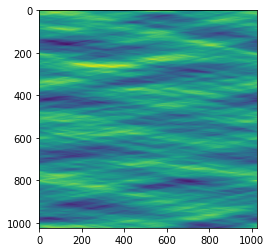

In [4]:
plt.imshow(data)
plt.show()

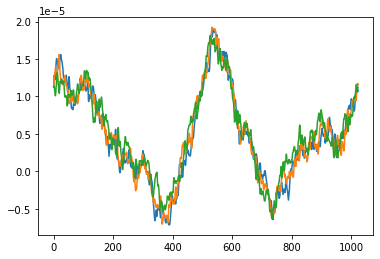

In [12]:
plt.plot(data[0,:])
plt.plot(data[1,:])
plt.plot(data[2,:])
plt.show()

In [11]:
print(data[0,0], data[0,-1])

1.14e-05 1.082e-05
